In [1]:
import tensorflow as tf

In [2]:
import cv2
import numpy as np
import os

In [3]:
len(os.listdir('/Users/atharvajoshi/Desktop/AI Image Colorizer/content/unlabeled2017'))

123404

Creating a custom batch dataloader for image dataset

In [4]:
class DataGenerator():
    def __init__(self, batch_size, folder_path, image_size):
        self.batch_size = batch_size
        self.folder_path = folder_path
        self.current_index = 0
        self.image_size = image_size

    def reset_index(self):
        self.current_index = 0
        print("Index reset to 0 successfully")

    def generate_image_path(self):
        images_path = []
        image_names = os.listdir(self.folder_path)

        for image in image_names:
            if image.split('.')[-1] == 'jpg':
                images_path.append(self.folder_path+'/'+image)

        return images_path

    def load_batch_path(self, imgpath_list):
        batch_paths = imgpath_list[self.current_index:self.current_index+self.batch_size]
        self.current_index = self.current_index + self.batch_size
        
        if self.current_index % 1600 == 0:
            print("Current Index is :"+ str(self.current_index))
            
        return batch_paths

    def length_total(self):
        length = len(self.generate_image_path())
        return length

    def load_batch(self):

        img_path = self.generate_image_path()
        current_batch = self.load_batch_path(img_path)

        X_batch = []
        Y_batch = []

        for image in current_batch:
            
            img_arr = cv2.imread(image)
            resized = cv2.resize(img_arr, (256,256))
            img_lab = cv2.cvtColor(resized,cv2.COLOR_BGR2LAB)
            lab_channels = cv2.split(img_lab)

            #Normalizing Channels
            normalized_l = lab_channels[0] / 127.5 - 1.
            normalized_ab = (cv2.merge((lab_channels[1],lab_channels[2])) - 128.) / 127.

            normalized_l = np.expand_dims(normalized_l,-1)
            normalized_l = np.float32(normalized_l)
            normalized_ab = np.float32(normalized_ab)
                
            

            X_batch.append(normalized_l)
            Y_batch.append(normalized_ab)


        return np.array(X_batch),np.array(Y_batch)
    

In [5]:
data_generator = DataGenerator(16, '/Users/atharvajoshi/Desktop/AI Image Colorizer/content/unlabeled2017', (256,256))

# Let's create our model

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import *
from tensorflow.keras import Model

In [7]:
# Generator Model
# Generate fake images based on previous data by using weights
# U-net Architeture


def Generator_model(input_image_dims):

    def conv2d(layer_input, filters, f_size=4, bn=True):
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same',use_bias=False,kernel_initializer=initializer)(layer_input)
        if bn:
            d = BatchNormalization(momentum=0.1, epsilon=1e-05)(d)
        d = LeakyReLU(alpha=0.2)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, dropout_rate, apply_dropout=True):
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)
        u = Conv2DTranspose(filters, kernel_size=4, strides=2, padding='same',use_bias=False,kernel_initializer=initializer)(layer_input)
        u = BatchNormalization(momentum=0.1, epsilon=1e-05)(u)
        u = Activation('relu')(u)
        
        if apply_dropout:
            u = Dropout(dropout_rate)(u)
            

        u = Concatenate()([u, skip_input])
        return u

    # Image input
    d0 = Input((256,256,1))
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)
    layer_one = Conv2D(64, 4, strides=2, padding='same',use_bias=False,kernel_initializer=initializer)(d0)
    layer_one = LeakyReLU(alpha=0.2)(layer_one)

    # Downsampling
    d1 = conv2d(layer_one, 64)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    
    
    d7 = conv2d(d6, 512)

    # Upsampling
    u1 = deconv2d(d7, d6, 512,0.5)
    u2 = deconv2d(u1, d5, 512,0.5)
    u3 = deconv2d(u2, d4, 512,0.5)
    u4 = deconv2d(u3, d3, 256,0.5)
    u5 = deconv2d(u4, d2, 128, 0.0,False)
    u6 = deconv2d(u5, d1, 64, 0.0,False)
    u7 = deconv2d(u6, layer_one, 64, 0.0,False)
    
    
    out = Conv2DTranspose(2, 4, strides=2, padding='same',activation='tanh',kernel_initializer=initializer)(u7)

    return Model(d0, out)

In [8]:
generator = Generator_model((256,256))

2022-02-02 19:24:41.472739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-02 19:24:41.472992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [9]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1024        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [10]:
# Discriminator Model
# Job Classification between Original and Fake(Generated by generator)
# Dual Classes Classifier

def Discriminator_model():
    
    initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)

    img_inp = Input(shape = (256, 256, 3))
 
    conv_1 = Conv2D(64,4,strides=2,padding='same',kernel_initializer=initializer,use_bias=False)(img_inp)
    act_1 = LeakyReLU(0.2)(conv_1)
 
    conv_2 = Conv2D(128,4,strides=2,padding='same',kernel_initializer=initializer,use_bias=False)(act_1)
    batch_norm_2 = BatchNormalization(momentum=0.1, epsilon=1e-05)(conv_2)
    act_2 = LeakyReLU(0.2)(batch_norm_2)
 
    conv_3 = Conv2D(256,4,strides=2,padding='same',kernel_initializer=initializer,use_bias=False)(act_2)
    batch_norm_3 = BatchNormalization(momentum=0.1, epsilon=1e-05)(conv_3)
    act_3 = LeakyReLU(0.2)(batch_norm_3)
 
    conv_4 = Conv2D(512,4,strides=1,padding='same',kernel_initializer=initializer,use_bias=False)(act_3)
    batch_norm_4 = BatchNormalization(momentum=0.1, epsilon=1e-05)(conv_4)
    act_4 = LeakyReLU(0.2)(batch_norm_4)
 
    conv_5 = Conv2D(1,4,strides=1,padding='same',kernel_initializer=initializer)(act_4)
 
    disc_model = Model(img_inp, conv_5)
    
    return disc_model


In [11]:
discriminator = Discriminator_model()

In [12]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 64)      3072      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       131072    
                                                                 
 batch_normalization_14 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                           

In [13]:
generator_optimizer = Adam(3.2e-5,0.5,0.999)
discriminator_optimizer = Adam(3.2e-5,0.5,0.999)

## Pretraining the generator on L1/MAE Loss

In [ ]:
pretrain_optimizer = Adam(3.2e-5,0.5,0.999)

In [ ]:
def pretrain_mae_loss(ab,ab_predicted):
    l1_loss = tf.reduce_mean(tf.abs(ab_predicted - ab))
    return l1_loss

In [ ]:
@tf.function
def pretrain_step(l,ab):
        
    with tf.GradientTape() as gen_tape:
        ab_predicted = generator(l, training=True)
        
        gen_loss = pretrain_mae_loss(ab,ab_predicted)
    
    
    generator_gradients = gen_tape.gradient(gen_loss,
                                            generator.trainable_variables)
    
    pretrain_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    
    return gen_loss
        

In [ ]:
def generator_pretraining(n_images,batch_size,num_epochs):
    
    len_epoch = n_images//batch_size
    
    for e in range(num_epochs):
        
        data_generator.reset_index()
        
        print("Epoch: "+str(e+1)+'/'+str(num_epochs))
    
        for i in range(len_epoch):

            l,ab = data_generator.load_batch()

            if (l.max() or ab.max()) > 1.0:
                print("Max value exceeded at image of index: "+str(i))
                break

            if (l.min() or ab.min()) < -1.0:
                print("Min value exceeded at image of index: "+str(i))
                break



            l = tf.convert_to_tensor(l)
            ab = tf.convert_to_tensor(ab)

            l1_loss = pretrain_step(l,ab)

            if i % 1000 == 0:
                print(str(i*batch_size)+' images completed')
                
                print("L1 Loss:"+str(l1_loss))

In [ ]:
train = generator_pretraining(50000,16,20)

In [ ]:
generator.save('generator_pretrain_20.h5')

## Training the GAN with pretrained Generator

In [14]:
LAMBDA = 100


def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = tf.reduce_mean(real_loss + generated_loss) * 0.5
    return total_disc_loss



def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.ones_like(disc_generated_output), disc_generated_output))
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [15]:
@tf.function
def train_step(l,ab,batch_size):
        
        
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        ab_predicted = generator(l, training=True)

        disc_real_output = discriminator(tf.keras.layers.concatenate([l, ab]), training=True)
        disc_generated_output = discriminator(tf.keras.layers.concatenate([l, ab_predicted]), training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, ab_predicted, ab)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    
    
    return gen_gan_loss,gen_total_loss,gen_gan_loss, gen_l1_loss
        

In [16]:
def gan_training(batch_size,n_images,num_epochs):
    
    len_epoch = n_images//batch_size
    
    for e in range(num_epochs):
        
        data_generator.reset_index()
        
        print("Epoch: "+str(e+1)+'/'+str(num_epochs))
    
        for i in range(len_epoch):

            l,ab = data_generator.load_batch()

            if (l.max() or ab.max()) > 1.0:
                print("Max value exceeded at image of index: "+str(i))
                break

            if (l.min() or ab.min()) < -1.0:
                print("Min value exceeded at image of index: "+str(i))
                break



            l = tf.convert_to_tensor(l)
            ab = tf.convert_to_tensor(ab)

            dis_loss,conditional_loss,gan_loss,l1_loss = train_step(l,ab,batch_size)

            if i % 1000 == 0:
                print(str(i)+' images completed')
                
                
                print("Discriminator Loss: "+str(dis_loss))
                print("Conditional Loss:"+str(conditional_loss))
                print("GAN Loss:"+str(gan_loss))
                print("L1 Loss:"+str(l1_loss))

In [17]:
import matplotlib.pyplot as plt

In [18]:
import tensorflow

In [19]:
generator = tensorflow.keras.models.load_model('generator_20.h5')
discriminator = tensorflow.keras.models.load_model('discriminator_20.h5')

In [20]:
def load_optimizer_state(optimizer, load_path, load_name, model_train_vars):
    '''
    Loads keras.optimizers object state.

    Arguments:
    optimizer --- Optimizer object to be loaded.
    load_path --- Path to save location.
    load_name --- Name of the .npy file to be read.
    model_train_vars --- List of model variables (obtained using Model.trainable_variables)

    '''

    # Load optimizer weights
    opt_weights = np.load(os.path.join(load_path, load_name)+'.npy', allow_pickle=True)

    # dummy zero gradients
    zero_grads = [tf.zeros_like(w) for w in model_train_vars]
    # save current state of variables
    saved_vars = [tf.identity(w) for w in model_train_vars]

    # Apply gradients which don't do nothing with Adam
    optimizer.apply_gradients(zip(zero_grads, model_train_vars))

    # Reload variables
    [x.assign(y) for x,y in zip(model_train_vars, saved_vars)]

    # Set the weights of the optimizer
    optimizer.set_weights(opt_weights)


    return

In [21]:
load_optimizer_state(generator_optimizer, '/Users/atharvajoshi/Desktop/AI Image Colorizer/optimizers/','generator_optimizer_20',generator.trainable_variables)

In [22]:
load_optimizer_state(discriminator_optimizer, '/Users/atharvajoshi/Desktop/AI Image Colorizer/optimizers/','discriminator_optimizer_20',discriminator.trainable_variables)

In [ ]:
train = gan_training(16,50000,5)

Index reset to 0 successfully
Epoch: 1/5


2022-02-02 19:24:56.085116: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-02 19:24:56.085311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0 images completed
Discriminator Loss: tf.Tensor(2.7215593, shape=(), dtype=float32)
Conditional Loss:tf.Tensor(8.264063, shape=(), dtype=float32)
GAN Loss:tf.Tensor(2.7215593, shape=(), dtype=float32)
L1 Loss:tf.Tensor(0.055425037, shape=(), dtype=float32)
Current Index is :1600
Current Index is :3200
Current Index is :4800
Current Index is :6400
Current Index is :8000
Current Index is :9600
Current Index is :11200
Current Index is :12800
Current Index is :14400
Current Index is :16000
1000 images completed
Discriminator Loss: tf.Tensor(1.7228122, shape=(), dtype=float32)
Conditional Loss:tf.Tensor(7.1306553, shape=(), dtype=float32)
GAN Loss:tf.Tensor(1.7228122, shape=(), dtype=float32)
L1 Loss:tf.Tensor(0.05407843, shape=(), dtype=float32)
Current Index is :17600
Current Index is :19200
Current Index is :20800
Current Index is :22400
Current Index is :24000
Current Index is :25600
Current Index is :27200
Current Index is :28800
Current Index is :30400
Current Index is :32000
2000 im

In [24]:
generator.save('generator_21.h5')
generator.save_weights('generator_21_weights.h5')

In [25]:
discriminator.save('discriminator_21.h5')
discriminator.save_weights('discriminator_21_weights.h5')

In [26]:
#https://stackoverflow.com/questions/49503748/save-and-load-model-optimizer-state


def save_optimizer_state(optimizer, save_path, save_name):
    '''
    Save keras.optimizers object state.

    Arguments:
    optimizer --- Optimizer object.
    save_path --- Path to save location.
    save_name --- Name of the .npy file to be created.

    '''

    # Create folder if it does not exists
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # save weights
    np.save(os.path.join(save_path, save_name), optimizer.get_weights())

    return

In [27]:
save_optimizer_state(generator_optimizer, '/Users/atharvajoshi/Desktop/AI Image Colorizer/optimizers/','generator_optimizer_25')

/Users/atharvajoshi/miniforge3/lib/python3.9/site-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [28]:
save_optimizer_state(discriminator_optimizer, '/Users/atharvajoshi/Desktop/AI Image Colorizer/optimizers/','discriminator_optimizer_25')

# Testing our model

Now let's try to give random samples to our model and lets see the outputs

In [29]:
def predict_image(img_path):
    
    img_arr = cv2.imread(img_path)
    resized = cv2.resize(img_arr, (256,256))
    img_lab = cv2.cvtColor(resized,cv2.COLOR_BGR2LAB)
    lab_channels = cv2.split(img_lab)
    
    #plt.imshow(lab_channels[0])

    #Normalizing Channels
    normalized_l = lab_channels[0] / 127.5 - 1.
    normalized_ab = (cv2.merge((lab_channels[1],lab_channels[2])) - 128.) / 127.

    normalized_l = np.expand_dims(normalized_l,-1)
    normalized_l = np.float32(normalized_l)
    normalized_ab = np.float32(normalized_ab)
    
    #final_lab = cv2.merge((normalized_l,normalized_ab))
    
    final = np.expand_dims(normalized_l,0)
    
    predicted_ab = generator.predict(final)
    
    squeezed = np.squeeze(predicted_ab)
    
    predicted_lab = cv2.merge((normalized_l,squeezed))
    
    
    pred_L = (predicted_lab[:,:,0] + 1.) * 50.
    pred_ab = (predicted_lab[:,:,1:] * 127.5)
    pred_L = np.float32(pred_L)
    pred_ab = np.float32(pred_ab)


    pred_lab = cv2.merge((pred_L,pred_ab))
    pred_lab = np.float32(pred_lab)

    pred_rgb = cv2.cvtColor(pred_lab,cv2.COLOR_LAB2RGB)

    pred_rgb_final = pred_rgb * 255
    final_pred_rgb = pred_rgb_final.astype(int)
    plt.imshow(final_pred_rgb)
    
    return predicted_ab,normalized_l

    
    

In [30]:
import matplotlib

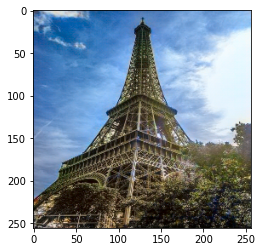

In [53]:
pred_ab,normalized_l = predict_image(os.getcwd()+'/pexels-photo-1461974.jpeg')

In [32]:
pred_ab.min()

-0.11338706

In [33]:
normalized_l.min()

-1.0